# Init

In [1]:
using LinearAlgebra
using NearestNeighbors
using StaticArrays
using Luxor
include("utils.jl"   )
include("kernels.jl" );

# Problem Domain

In [2]:
_DIM_X    = 4
_DIM_A    = 1
Fmax      = 10.0 #7.5 #15.0 #25.0 #5.0 #10.0 #20.0
Fdiv      = 4.0 #8.0 # 4.0
_X_DOMAIN = [ -30.0 +30.0 ; # thetaDotDot
              -15.0 +15.0 ; # thetaDot
              -20.0 +20.0 ; # theta
              # -10.0 +10.0 ] # xDot
              -10.0 +10.0 ] # xDot
              # -50.0 +50.0 ] # xDot
_A_DOMAIN = [ -Fmax +Fmax ]
_Q_DOMAIN = [_X_DOMAIN; _A_DOMAIN]
_LEAFLEN  = 10;

nX = _DIM_X; # ---- State    dims
nA = _DIM_A; # ---- Action   dims
nQ = nX + nA; # --- Combined dims
X  = zeros( nX ); # Current position
A  = zeros( nA ); # Current effort
Q  = zeros( nQ ); # Current Q state

include("env_cartpole.jl");

In [3]:
"""
Assemble <State,Action> into Q-state
"""
function get_Q( X, A )
    res = zeros( nQ );
    res[ 1:nX ] = X[:];
    if typeof( A ) == Float64
        res[ nX+1 ] = A;
    else
        res[ nX+1:nQ ] = A;
    end
    return res;
end


"""
Disassemble <State,Action> into Q-state
"""
function XA_from_Q( Q )
    return Q[ 1:nX ], Q[ nX+1:nQ ];
end

"""
Select the relvant variables from the state vector
"""
function select_X_vector( Xbig )
    return [ Xbig[1], Xbig[2], Xbig[3], Xbig[5] ]
end

select_X_vector

# Agent

## Agent Structures

In [4]:
Fres = Fmax/Fdiv
# Fres = 1.0 #2.0 #1.0

# Construct grid of anchors
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 1.0, 1.0, 1.0, 1.0, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 2.0, 2.0, 2.0, 2.0, Fres ] );
G    = regular_grid_pts_nD( _Q_DOMAIN, [ 4.0, 4.0, 4.0, 4.0, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 5.0, 5.0, 5.0, 5.0, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 7.5, 7.5, 7.5, 7.5, Fres ] );
# G    = regular_grid_pts_nD( _Q_DOMAIN, [ 12.0, 8.0, 12.0, 8.0, Fres ] );
nPts = size( G )[2]; # - Number of anchors
mDim = size( G )[1]; # - Dimensionality of anchors 
V    = zeros(Float64, nPts); # Values at anchors
VS   = zeros(Float64, nPts); # Scratch values
vsts = zeros(Int64, nPts); # - Set number of visits to zero
println( size( G ) )

# Construct spatial trees over anchors (WITHOUT reordering!)
Q_kdTree = KDTree( G            ; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
X_kdTree = KDTree( G[1:_DIM_X,:]; leafsize = _LEAFLEN, reorder = false ); # Vals must remain assoc w pnts!
Q_blTree = BallTree( G             ); 
X_blTree = BallTree( G[1:_DIM_X,:] ); 

(5, 76032)


## Agent Params

In [5]:
##### Params #####
scale = 7.0; #1.650; # ----------- scale
vNN   =  5 #10 #4 #6 #3 # Value nearest neighbors
bNN   =  1; #1 # Blend nearest neighbors

@assert Fres < scale "!! `scale` SET TOO LOW !!"

## Helper Functions

In [6]:
"""
Normalize `theta` to shortest angle to zero
"""
function norm_turn( theta )
    thetaN = abs( theta % (2*pi) )
    if thetaN > pi
        thetaN = (2*pi) - thetaN
    end
    return thetaN
end


"""
Reward high speed at the bottom and low speed at the top
"""
function cartpole_reward( X )
    
    # 0. Set limits
    maxThetaDot =  10.0
    maxX        =   2.0
    # 1. Set weights
    thFactor    = 100.0
    thDotFactor =   8.0
    
    # 2. Unpack & Normalize state
    thetaDotN   = abs( X[2] ) # ----- Angular velocity
    thetaN      = X[3] # Angle
    xN          = abs( X[6] ) # ----- Fulcrum position
    # 3. Reward high speed at the bottom and low speed at the top
    R = thFactor*cos(thetaN) - thDotFactor*cos(thetaN)*(thetaDotN)
    
    
    if xN > maxX
        R -= xN
    end
    # if thetaDotN > maxThetaDot
    #     R -= thetaDotN
    # end
    return R
end


"""
Given a state `X`, determine the best action
"""
function optimal_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   = 0.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = cartpole_reward( Xp )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_fuzzy( 
            Q_kdTree, G, V, 
            get_Q( 
                select_X_vector( Xp ), 
                A 
            ); 
            k = vNN 
        )
        if (Ra != 0.0) && (Ra > bestR)
            bestR = Ra
            bestA = A
        end
    end
    # println( bestR )
    return bestA
end


"""
Given a state `X`, determine the best action
"""
function learned_action_for_state_exp( X, domain, res, ts )
    testPts = regular_grid_pts_nD( domain, res )[:]
    N       = length( testPts )
    bestR   = -1000.0
    bestA   =  1000.0
    # println( testPts )
    for j = 1:N
        A  = testPts[j]
        Xp = cartpole_dyn( X, A, ts )
        Ra = query_value_fuzzy_exp( 
            Q_kdTree, G, V, 
            get_Q( 
                select_X_vector( Xp ), 
                A 
            ); 
            k = vNN 
        )
        if Ra > bestR
            bestR = Ra
            bestA = A
        end
    end
    # println( bestR )
    return bestA
end


"""
Return number of seconds that penulum was within double-sided `angleMargin` of vertical
"""
function vertical_score_s( stateHistory, angleMargin, ts )
    angles = stateHistory[3,:]
    N      = length( angles )
    score  = 0.0
    # println( "vertical_score_s: Analize series of ", N, " timesteps." )
    for j = 1:N
        if abs( angles[j] ) <= angleMargin
            score += ts
        end
    end
    return score
end

vertical_score_s

# Optimal Agent

In [7]:
dur_s     = 40
ts        = 0.01
T         = Int64((1/ts)*dur_s)
N_0       = N_cart( 0.0, 0.0, pi/2.0 )
X_0       = [ 0.0, 0.0, pi, 0.0, 0.0, 10.0 , N_0 ]
states    = zeros( size( X_0, 1 ), T )
actions   = zeros( T );
bestXs    = zeros( size( X_0, 1 ), T )
bestAs    = zeros( T );

In [8]:
vSwp = zeros(Float64, nPts); # Swap values
vBst = zeros(Float64, nPts); # Best values
vBAv = zeros(Float64, nPts); # Values for best average
vBlA = zeros(Float64, nPts); # Values for best average
vAll = zeros(Float64, nPts); # Absorbs all training

In [9]:
vB25 = zeros(Float64, nPts); # Best 25 : Train 75
vB50 = zeros(Float64, nPts); # Best 50 : Train 50
vB75 = zeros(Float64, nPts); # Best 75 : Train 25
vB90 = zeros(Float64, nPts); # Best 90 : Train 10
vB95 = zeros(Float64, nPts); # Best 95 : Train  5

In [10]:
"""
Blend two vectors by element
"""
function blend_alpha_of_A_into_B( alpha, A, B )
    return A*alpha + B*(1.0 - alpha)
end


"""
Exchange nonzero values
"""
function exchange_nonzeros( A, B )
    rtnA = zeros( size(A, 1) )    
    rtnB = zeros( size(B, 1) )
    N    = size(A, 1)
    for j = 1:N
        
        # Handle A
        if A[j] == 0.0
            rtnA[j] = B[j]
        else
            rtnA[j] = A[j]
        end
        
        # Handle B
        if B[j] == 0.0
            rtnB[j] = A[j]
        else
            rtnB[j] = B[j]
        end
    end
    
    return rtnA, rtnB
end

exchange_nonzeros


Epoch 1, Best Score: -100.0, Best Average: -100.0
Training Iteration 4 score: 0.20000000000000004, epsilon: 0.47890625000000003
Training Iteration 8 score: 0.0, epsilon: 0.4507812500000001
Training Iteration 12 score: 0.0, epsilon: 0.4226562500000001
Training Iteration 16 score: 0.0, epsilon: 0.39453125000000017
Training Iteration 20 score: 0.10999999999999999, epsilon: 0.3664062500000002
Training Iteration 24 score: 0.09999999999999999, epsilon: 0.33828125000000026
Training Iteration 28 score: 0.10999999999999999, epsilon: 0.3101562500000003
Training Iteration 32 score: 0.0, epsilon: 0.28203125000000034
Training Iteration 36 score: 0.10999999999999999, epsilon: 0.2539062500000004
Training Iteration 40 score: 0.12999999999999998, epsilon: 0.22578125000000043
Training Iteration 44 score: 0.0, epsilon: 0.19765625000000048
Training Iteration 48 score: 0.0, epsilon: 0.16953125000000052
Training Iteration 52 score: 0.35000000000000014, epsilon: 0.14140625000000057
Training Iteration 56 sco

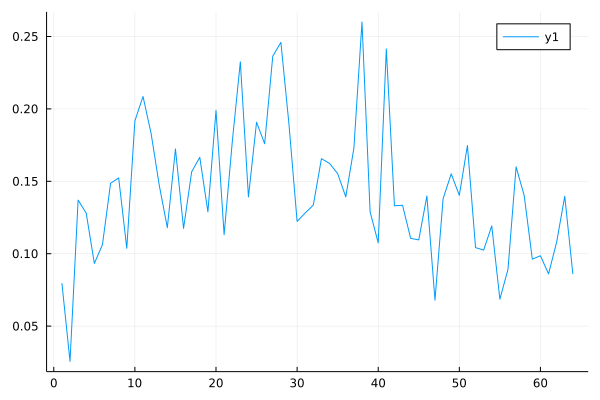

In [11]:
gamma     = 0.99 #0.75 #0.950; # ---------- FIXME
epsMin    = 0.05 # 0.05
epsMax    = 0.50 #0.50 #0.15 #0.50 # 0.3 # 0.75 # 1.00
episodes  =  64 # 32 #64 #2048 #1024 #128 #512 #256 #20 # 160 # 40 # 80
epochs    =  64 #128 #64 # 32 #16
EXPrand   = 1.00 #0.25 #0.5 # 0.75
bgn       = time()
Alpha     = 0.875
bestScore = -100.0;
bestAvg   = -100.0;
averages  = []
aMargin   = (pi/180)*15.0;

for m = 1:epochs
    
    println( "\nEpoch ", m, ", Best Score: ", bestScore, ", Best Average: ", bestAvg )
    
    epsilon = epsMax 
    deltaEp = (epsMax - epsMin)/episodes
    s_Prev  = 0.0
    s_Totl  = 0.0
    
    # V = blend_alpha_of_A_into_B( 0.75, vBst, V ) # 0.25 # 0.50 # 0.75
    
    # if m % 2 == 0
    #     V = copy( vBst )
    # end
    
    # V        = copy( vBst )
    # VS, vBst = exchange_nonzeros( VS, vBst )
    
    for l = 1:episodes
        X  = X_0

        for k = 1:T

            # 1. Choose action
            if rand() < epsilon
                # A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                if rand() < EXPrand 
                    A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                else
                    A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                end
            else

                A = learned_action_for_state( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                if A == 1000.0 # Indicates no values in this region
                    if rand() < EXPrand 
                        A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
                    else
                        A = optimal_action_for_state( X, _A_DOMAIN, [ Fres ], ts )
                    end
                end
                
                # A = learned_action_for_state_exp( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )

            end

            # 2. Cache last state
            # println( typeof( select_X_vector( X ) ) )
            # println( typeof( A ) )
            qLast = get_Q( select_X_vector( X ), A )

            # 3. Generate the next stae
            Xp = cartpole_dyn( X, A, ts )
            # println( "Xp: ", Xp )

            # 4. Collect reward R( s, a, s' )
            R_t = cartpole_reward( Xp )
            # println( "R_t: ", R_t )

            # 5. Get the optimal action at the next state
            a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fres ], ts )
            # a_tp1_opt = learned_action_for_state( Xp, _A_DOMAIN, [ Fmax/Fdiv ], ts )
            # if a_tp1_opt == 1000.0 # Indicates no values in this region
            #     a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fmax/Fdiv ], ts )
            # end

            # 6. Compute the value at the next state

            V_tp1_opt = query_value_fuzzy( 
            # V_tp1_opt = query_value_fuzzy_exp( 

                Q_kdTree, G, V, 
                get_Q( 
                    select_X_vector( Xp ), 
                    a_tp1_opt 
                ); 
                k = vNN 
            )
            if isnan( V_tp1_opt )
                V_tp1_opt = 0.0
            end

            # println( "R_t: ", R_t, "V_tp1: ", V_tp1_opt )


            # 7. Blend the value back into nearest points

            idxs, wgts = query_contrib_to_neighbors( Q_kdTree, G, V, qLast; k = bNN )
            # idxs, wgts = query_contrib_to_neighbors_exp( Q_kdTree, G, V, qLast; k = bNN )

            nNear      = size( idxs, 1 )
            for i = 1:nNear
                j    = idxs[i]
                if !isnan( wgts[i] ) 

                    VS[j]   =  R_t + gamma * V_tp1_opt # --------------------------------- 0.66 | 20.9
                    vAll[j] =  R_t + gamma * V_tp1_opt # --------------------------------- 0.66 | 20.9
                    
                    # VS[j] = wgts[i] * ( R_t + gamma * V_tp1_opt ) # -------------------- 0.20 |  0.3
                    # VS[j] = R_t + wgts[i] * ( gamma * V_tp1_opt ) # -------------------- 0.04 |  8.9
                    # VS[j] = ( 1.0 - wgts[i] )*R_t + wgts[i]*( gamma * V_tp1_opt ) # ---- 0.52 |  3.9
                    # VS[j] = wgts[i]*R_t + gamma*V_tp1_opt # ---------------------------- 0.00 |  4.3
                    # VS[j] = (1.0 - wgts[i])*V[j] + wgts[i]*( R_t + gamma * V_tp1_opt ) # 0.00 |  1.6
                    
                end
                # println( [i j], " ", V[j] )
            end

            states[:,k] = Xp
            actions[k]  = A

            X = Xp
        end

        s_l    = vertical_score_s( states, aMargin, ts )
        s_Totl += s_l
        # s_l = (1.0 - Alpha)*s_Prev  + Alpha*vertical_score_s( states, aMargin, ts )
        if s_l > bestScore
            bestScore = s_l
            bestXs    = copy( states  )
            bestAs    = copy( actions )
            vBst      = copy( V )
        end
        
        if l%4 == 0
            println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        end
        
        # if s_l > s_Prev
        #     epsilon -= deltaEp
        # end
        epsilon -= deltaEp

        # if l%2 == 0
        #     vSwp = copy( VS   )
        #     VS   = copy( V    )
        #     V    = copy( vSwp )
        #     println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        # end
        
        # if l%2 == 0
        #     V = copy( VS )
        #     println( "Training Iteration ", l, " score: ", s_l, ", epsilon: ", epsilon )
        # else
        #     V = copy( vBst )
        # end
        
        vSwp = copy( VS   )
        VS   = copy( V    )
        V    = copy( vSwp )
        
        # s_Prev = s_l
    end
    
    s_Avg = s_Totl / episodes
    println( "Average Score: ", s_Avg )
    
    append!( averages, s_Avg )
    
    if s_Avg > bestAvg
        bestAvg = s_Avg
        vBAv    = copy( V ) # Try a blend of both next
        vBlA    = blend_alpha_of_A_into_B( 0.50, VS, V )
    end
    
end

vTrn = copy( V )
println( "Saved a trained Q-table with size ", size( vTrn ), ", After ", (time()-bgn)/60.0, " minutes of training!" )

using Plots

plot( averages )

In [12]:
println( "Best Score: ", bestScore, " [s]" )


Best Score: 3.1599999999999766 [s]


In [13]:
"""
Return fraction of elements that are nonzero
"""
function vector_fullness( vec )
    N = size( vec, 1 )
    c = 0
    for j = 1:N
        if vec[j] != 0.0
            c += 1
        end
    end
    return c/N
end

vector_fullness

In [14]:
println( "Alternate Weights are ", vector_fullness( VS   ), " full" )
println( "Trained   Weights are ", vector_fullness( vTrn ), " full" )
println( "Best      Weights are ", vector_fullness( vBst ), " full" )

Alternate Weights are 0.5626709806397306 full
Trained   Weights are 0.5549900042087542 full
Best      Weights are 0.38804713804713803 full


# Optimal Iteration

In [15]:
"""
Use the desginated value table to navigate cartpole env
WARNING: This function OVERWRITES `V`!, so make sure to save the Q-tables that you need ELSEWHERE!!
"""
function optimal_cartpole_agent_P2_episode( Vfunc, T, X_0, ts, epsilon )
    global V
    
    # Init #
    V      = copy( Vfunc )
    record = zeros( size( X_0, 1 ), T ) # Recording of all system states
    s_Totl = 0.0
    X      = X_0

    for k = 1:T

        # 1. Choose action
        if rand() < epsilon
            A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
        else

            A = learned_action_for_state( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
            if A == 1000.0 # Indicates no values in this region
                # A = optimal_action_for_state( X, _A_DOMAIN, [ Fmax/Fdiv ], ts )
                A = sample_uniform_real( _A_DOMAIN[1] , _A_DOMAIN[2] )
            end
        end

        # 3. Generate the next stae
        Xp = cartpole_dyn( X, A, ts )

        record[:,k] = Xp

        X = Xp
    end

    return record
    
end

optimal_cartpole_agent_P2_episode

In [16]:
println( "Best Score: ", bestScore, " [s]" )


Best Score: 3.1599999999999766 [s]


In [17]:
episodes = 20
scoreSum = 0.0
trials   = [ 0.05, 0.075, 0.0875, 0.10, 0.1125, 0.125, 0.15, 0.1625, 0.175, 0.1875, 0.20 ]  

for trlEps in trials
    
    scoreSum = 0.0
    
    for epNo = 1:episodes

        res = optimal_cartpole_agent_P2_episode( vTrn, T, X_0, ts, trlEps )
        s_e = vertical_score_s( res, aMargin, ts )
        scoreSum += s_e
        if epNo % 5 == 0
            println( "\tEp ", epNo, ", Score: ", s_e )
        end

    end
    println( "Average Trained Score (out of ", episodes, "): ", scoreSum/episodes, ", epsilon = ", trlEps, "\n" )
end



	Ep 5, Score: 0.09
	Ep 10, Score: 0.36000000000000015
	Ep 15, Score: 0.23000000000000007
	Ep 20, Score: 0.18000000000000002
Average Trained Score (out of 20): 0.1985, epsilon = 0.05

	Ep 5, Score: 0.09999999999999999
	Ep 10, Score: 0.23000000000000007
	Ep 15, Score: 0.09999999999999999
	Ep 20, Score: 0.19000000000000003
Average Trained Score (out of 20): 0.159, epsilon = 0.075

	Ep 5, Score: 0.19000000000000003
	Ep 10, Score: 0.12999999999999998
	Ep 15, Score: 0.17
	Ep 20, Score: 0.17
Average Trained Score (out of 20): 0.16899999999999998, epsilon = 0.0875

	Ep 5, Score: 0.20000000000000004
	Ep 10, Score: 0.09999999999999999
	Ep 15, Score: 0.09
	Ep 20, Score: 0.09
Average Trained Score (out of 20): 0.1355, epsilon = 0.1

	Ep 5, Score: 0.10999999999999999
	Ep 10, Score: 0.18000000000000002
	Ep 15, Score: 0.4000000000000002
	Ep 20, Score: 0.10999999999999999
Average Trained Score (out of 20): 0.1375, epsilon = 0.1125

	Ep 5, Score: 0.16
	Ep 10, Score: 0.09
	Ep 15, Score: 0.18000000000000

In [18]:
# Best 75 : Train 25
# vB75 = blend_alpha_of_A_into_B( 0.75, vBst, vTrn )
# vB71 = blend_alpha_of_A_into_B( 0.7188, vBst, vBAv )
# vB75 = blend_alpha_of_A_into_B( 0.75, vBst, vAll )

eps = 0.000

if vertical_score_s( optimal_cartpole_agent_P2_episode( vBAv, T, X_0, ts, eps ), aMargin, ts ) > vertical_score_s( optimal_cartpole_agent_P2_episode( vBst, T, X_0, ts, eps ), aMargin, ts )
    println( "Chose vBAv as primary!" )
    vAug, _ = exchange_nonzeros( vBAv, vBst ) # LARGE improvement
else
    println( "Chose vBst as primary!" )
    vAug, _ = exchange_nonzeros( vBst, vBAv )
end


if vertical_score_s( optimal_cartpole_agent_P2_episode( VS, T, X_0, ts, eps ), aMargin, ts ) > vertical_score_s( optimal_cartpole_agent_P2_episode( vTrn, T, X_0, ts, eps ), aMargin, ts )
    println( "Chose VS as secondary!" )
    vAug, _ = exchange_nonzeros( vAug, VS )
    vAug, _ = exchange_nonzeros( vAug, vTrn )
else
    println( "Chose vTrn as secondary!" )
    vAug, _ = exchange_nonzeros( vAug, vTrn )
    vAug, _ = exchange_nonzeros( vAug, VS )
end

episodes = 100
scoreSum = 0.0
trials   = [ 0.00, 0.01, 0.025, 0.05, 0.0625, 0.075, 0.0875, 0.10, 0.125, 0.1375, 0.15, 0.1625, 0.175, 0.1875, 0.20 ]  

for trlEps in trials
    
    scoreSum = 0.0
    
    for epNo = 1:episodes

        res = optimal_cartpole_agent_P2_episode( vAug, T, X_0, ts, trlEps )
        s_e = vertical_score_s( res, aMargin, ts )
        scoreSum += s_e
        if epNo % 10 == 0
            println( "\tEp ", epNo, ", Score: ", s_e )
        end

    end
    println( "Average vAug Score (out of ", episodes, "): ", scoreSum/episodes, ", epsilon = ", trlEps, "\n" )
end

Chose vBst as primary!
Chose vTrn as secondary!
	Ep 10, Score: 0.4300000000000002
	Ep 20, Score: 0.4300000000000002
	Ep 30, Score: 0.4300000000000002
	Ep 40, Score: 0.4300000000000002
	Ep 50, Score: 0.4300000000000002
	Ep 60, Score: 0.4300000000000002
	Ep 70, Score: 0.4300000000000002
	Ep 80, Score: 0.4300000000000002
	Ep 90, Score: 0.4300000000000002
	Ep 100, Score: 0.4300000000000002
Average vAug Score (out of 100): 0.4299999999999999, epsilon = 0.0

	Ep 10, Score: 0.18000000000000002
	Ep 20, Score: 0.15
	Ep 30, Score: 0.6900000000000004
	Ep 40, Score: 0.09
	Ep 50, Score: 0.5400000000000003
	Ep 60, Score: 0.0
	Ep 70, Score: 0.19000000000000003
	Ep 80, Score: 0.5100000000000002
	Ep 90, Score: 0.7500000000000004
	Ep 100, Score: 0.35000000000000014
Average vAug Score (out of 100): 0.21350000000000008, epsilon = 0.01

	Ep 10, Score: 0.07
	Ep 20, Score: 0.09
	Ep 30, Score: 0.07
	Ep 40, Score: 0.24000000000000007
	Ep 50, Score: 0.23000000000000007
	Ep 60, Score: 0.12999999999999998
	Ep 70,

In [19]:
episodes = 100
scoreSum = 0.0
trials   = [ 0.00, 0.01, 0.025, 0.05, 0.0625, 0.075, 0.0875, 0.10, 0.125, 0.1375, 0.15, 0.1625, 0.175, 0.1875, 0.20 ]  

for trlEps in trials
    
    scoreSum = 0.0
    
    for epNo = 1:episodes

        res = optimal_cartpole_agent_P2_episode( vBst, T, X_0, ts, trlEps )
        s_e = vertical_score_s( res, aMargin, ts )
        scoreSum += s_e
        if epNo % 10 == 0
            println( "\tEp ", epNo, ", Score: ", s_e )
        end

    end
    println( "Average Best Score (out of ", episodes, "): ", scoreSum/episodes, ", epsilon = ", trlEps, "\n" )
end

	Ep 10, Score: 2.5999999999999885
	Ep 20, Score: 2.5999999999999885
	Ep 30, Score: 2.5999999999999885
	Ep 40, Score: 2.5999999999999885
	Ep 50, Score: 2.5999999999999885
	Ep 60, Score: 2.5999999999999885
	Ep 70, Score: 2.5999999999999885
	Ep 80, Score: 2.669999999999987
	Ep 90, Score: 2.5899999999999888
	Ep 100, Score: 2.5999999999999885
Average Best Score (out of 100): 2.6061999999999905, epsilon = 0.0

	Ep 10, Score: 0.09
	Ep 20, Score: 2.3599999999999937
	Ep 30, Score: 0.0
	Ep 40, Score: 3.7799999999999634
	Ep 50, Score: 0.21000000000000005
	Ep 60, Score: 0.09
	Ep 70, Score: 0.9200000000000006
	Ep 80, Score: 0.07
	Ep 90, Score: 0.09999999999999999
	Ep 100, Score: 0.4300000000000002
Average Best Score (out of 100): 0.5548999999999988, epsilon = 0.01

	Ep 10, Score: 0.12999999999999998
	Ep 20, Score: 0.12999999999999998
	Ep 30, Score: 0.10999999999999999
	Ep 40, Score: 0.09999999999999999
	Ep 50, Score: 0.11999999999999998
	Ep 60, Score: 0.10999999999999999
	Ep 70, Score: 0.0
	Ep 80, 

In [20]:
"""
Create an animated GIF of a cartpole state sequence
"""
function render_cartpole_episode( Xs, ts )
    
    # 0. Init
    FPS  = 30
    T    = size( Xs, 2 )
    skip = Int64( floor((1/FPS)/ts) )
    frms = Int64( ceil(T/skip) )

    # 1. Background func
    function backdrop(scene, framenumber)
        background("grey50")
    end

    # 2. Per frame func
    function frame( scene, framenumber )

        # Extract relevant state
        theta = Xs[3,(framenumber-1)*skip+1]
        x     = Xs[6,(framenumber-1)*skip+1]/4
        
        # Track
        sethue("blue")
        rule(Point(0, 0), 0.0)

        # Cart
        sethue("black")
        box(Point(x, 0), 70,  40, action = :fill)

        # Pole
        sethue("white")
        Luxor.translate( x, 0 )
        Luxor.translate( @polar (-100, theta+pi/2.0) )
        Luxor.rotate( theta )
        box(Point(0, 0), 15, 200, action=:fill)

    end

    # 3. Instantiate movie
    demo = Movie(800, 800, "test")

    # 4. Populate movie
    Luxor.animate( demo, [
        Scene(demo, backdrop, 1:frms),
        Scene(demo, frame, 1:frms)
    ], creategif=true)
end

render_cartpole_episode

┌ Info: Frames for animation "test" are being stored in directory: 
│ 	 /tmp/jl_7oLf8I
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:195
┌ Info: ... 1334 frames saved in directory:
│ 	 /tmp/jl_7oLf8I
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:217
┌ Info: GIF is: /tmp/jl_7oLf8I/test.gif
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:246


Luxor.AnimatedGif("/tmp/jl_7oLf8I/test.gif")
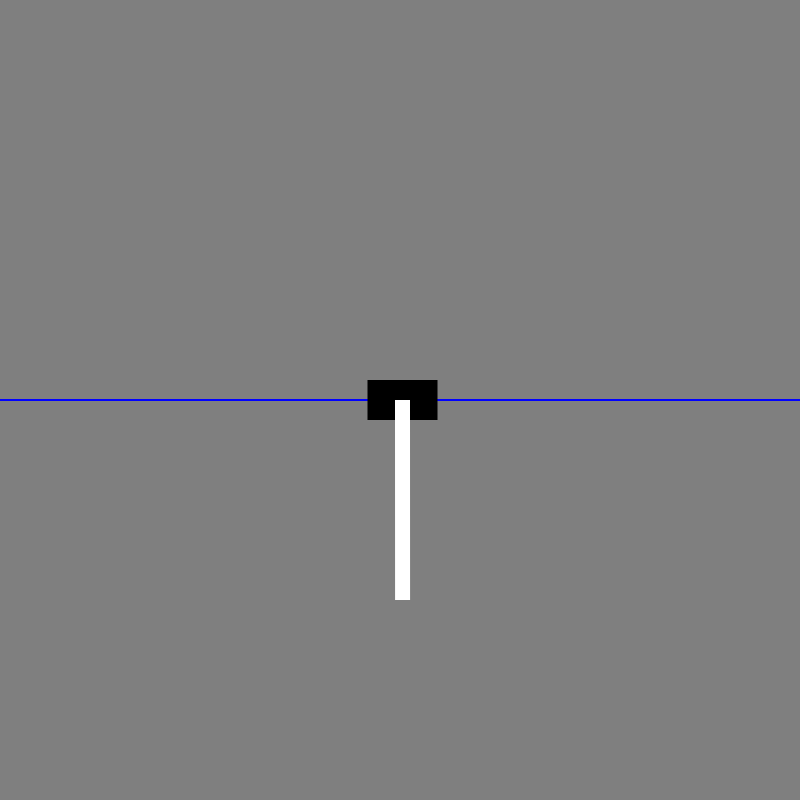

In [21]:
render_cartpole_episode( bestXs, ts )

# Spare Parts

In [22]:
if false
    Xmin, _ = findmin( bestXs, dims=2 )
    Xmax, _ = findmax( bestXs, dims=2 )
    println( "Xmin" )
    display( Xmin )
    println( "\nXmax" )
    display( Xmax )
end

## Corpus Learning Iteration

In [23]:
"""
One learning step from one predefined Q-state
"""
function corpus_iteration( X, A, ts )
    global G, V
    
    # 1. Unpack state
    # thetaDotDot = X[1] # Angular acceleration
    # thetaDot    = X[2] # Angular velocity
    # theta       = X[3] # Angle
    # xDotDot     = X[4] # Linear acceleration
    # xDot        = X[5] # Linear velocity
    # x           = X[6] # Fulcrum position
    # N_c         = X[7] # Normal force of the cart on the track
    
    # 2. Cache last state
    # println( typeof( select_X_vector( X ) ) )
    # println( typeof( A ) )
    qLast = get_Q( select_X_vector( X ), A )
    
    # 3. Generate the next stae
    Xp = cartpole_dyn( X, A, ts )
    # println( "Xp: ", Xp )
    
    # 4. Collect reward R( s, a, s' )
    R_t = cartpole_reward( Xp )
    # println( "R_t: ", R_t )
    
    # 5. Get the optimal action at the next state
    a_tp1_opt = optimal_action_for_state( Xp, _A_DOMAIN, [ Fmax/Fdiv ], ts )
    
    # 6. Compute the value at the next state
    
    V_tp1_opt = query_value_fuzzy( 
    # V_tp1_opt = query_value_fuzzy_exp( 
        Q_kdTree, G, V, 
        get_Q( 
            select_X_vector( Xp ), 
            a_tp1_opt 
        ); 
        k = vNN 
    )
    if isnan( V_tp1_opt )
        V_tp1_opt = 0.0
    end
    
    # 7. Blend the value back into nearest points
    
    idxs, wgts = query_contrib_to_neighbors( Q_kdTree, G, V, qLast; k = bNN )
    # idxs, wgts = query_contrib_to_neighbors_exp( Q_kdTree, G, V, qLast; k = bNN )
    
    nNear      = size( idxs, 1 )
    for i = 1:nNear
        j    = idxs[i]
        if !isnan( wgts[i] ) 
            V[j] =  R_t + gamma * V_tp1_opt # -------------------------------- 0.8 | 6.06
            # V[j] = wgts[i] * ( R_t + gamma * V_tp1_opt ) # --------------------
            # V[j] = R_t + wgts[i] * ( gamma * V_tp1_opt ) # --------------------
            # V[j] = ( 1.0 - wgts[i] )*R_t + wgts[i]*( gamma * V_tp1_opt ) # ---- 
            # V[j] = wgts[i]*R_t + gamma*V_tp1_opt # ----------------------------
            # V[j] = (1.0 - wgts[i])*V[j] + wgts[i]*( R_t + gamma * V_tp1_opt ) # 
        end
        # println( [i j], " ", V[j] )
    end
    
end

corpus_iteration

# Generate Corpus

In [24]:
dur_s   = 40
ts      = 0.01
T       = Int64((1/ts)*dur_s)
N_0     = N_cart( 0.0, 0.0, pi/2.0 )
X_0     = [ 0.0, 0.0, pi, 0.0, 0.0, 10.0 , N_0 ]
pers    = [ 0.0625, 0.0702, 0.078, 0.0859, 0.0938, 0.11, 0.125, 0.1875, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0 ]
data    = zeros( size( pers, 1 ), size( X_0, 1 ), T )
acts    = zeros( size( pers, 1 ), T )
X       = X_0
i       = 0

# 2022-11-30: CORPUS HARMS PERFORMANCE
if false
    for period in pers
        i += 1
        data[i,:,1] = X_0
        for j = 2:T
            t  = (j-1)*ts
            A  = -Fmax * cos( (t/period)*2*pi )
            Xp = cartpole_dyn( X, A, ts )
            data[i,:,j] = Xp 
            acts[i,j]   = A
            X = Xp
        end
    end
end

# Learn Corpus

In [25]:
# 2022-11-30: CORPUS HARMS PERFORMANCE
if false
    i = 0
    for period in pers
        i += 1
        for j = 1:T
            X = data[i,:,j]
            A = acts[i,j]
            corpus_iteration( X, A, ts )
        end
        println( "Corpus Iteration ", i, " score: ", vertical_score_s( data[i,:,:], aMargin, ts ) )
    end
else
    println( "Corpus training SKIPPED!" )
end

Corpus training SKIPPED!
